<h1>3rd try with ADAM, 1130, new layere design</h1>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import numpy as np
import tensorflow as tf # changed to intel-optimized build
%load_ext tensorboard

tf.random.set_seed(42)
np.random.seed(42)

import shutil
import gc
import time
import datetime
import random
from winsound import Beep
from PIL import Image
import pickle
def beep():
    Beep(1000, 100)
    
beep()
# %load_ext tensorboard
# %reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12,8]

In [6]:
addr = r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env"
os.chdir(addr)

<h1>load super-expanded training data</h1>

In [7]:
with open('f_data.pkl', 'rb') as f:
    [train_x, val_x, test_x, train_y, val_y, test_y] = pickle.load(f)
beep()

<h1>sample training data</h1>

In [8]:
# sample training data
n = len(train_x)
sn = int(n / 10)
np.random.seed(42)
index = np.random.choice([i for i in range(n)], size=sn, replace=False)

sub_tx, sub_ty = [], []

for ind in index:
    sub_tx.append(train_x[ind])
    sub_ty.append(train_y[ind])

sub_tx = np.array(sub_tx)
sub_ty = np.array(sub_ty)
sub_tx = sub_tx.reshape(np.shape(sub_tx)[0], np.shape(sub_tx)[1], np.shape(sub_tx)[2], 1)

beep()

gc.collect()

0

<h1>Useful functions:</h1>

In [11]:
# ######################################################################################
# ## delete all tensorboard logs: (it gets messy when there are too many files)
# p = './logs/'
# shutil.rmtree(p, ignore_errors=True)

<h1>garbage collect</h1>

In [9]:
gc.collect()

0

<h1>Build Network models</h1>

In [13]:
def build_adam_model_1129(
    lmbda,
    n_eph,
    batch_size,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax
    ):
    #############################################################
    tf.random.set_seed(42)
    #############################################################
    print('lmbda= {}\n'.format(lmbda))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    print('learning_rate= {}\n'.format(learning_rate))
    print('beta_1= {}\n'.format(beta_1))
    print('beta_2= {}\n'.format(beta_2))
    print('epsilon= {}\n'.format(epsilon))
    #############################################################
    
    model = tf.keras.models.Sequential()

    model.add(
        tf.keras.layers.Conv2D( # no padding
            32,
            (5,5),
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            ),
            input_shape=input_shape
        )
    )

    model.add(
        tf.keras.layers.MaxPool2D(
            pool_size=(3,3), # following example of Kingma & Ba, arXiv:1412.6980v9
            strides=(2,2)
        )
    )

    model.add(
        tf.keras.layers.Conv2D( # no padding
            32,
            (5,5),
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            )
        )
    )

    model.add(
        tf.keras.layers.MaxPool2D(
            pool_size=(2,2),
            strides=(2,2)
        )
    )

    model.add(
        tf.keras.layers.Flatten()
    )

    model.add(
        tf.keras.layers.Dense(
            1000,
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            )
        )
    )

    model.add(
        tf.keras.layers.Dense(
            10,
            activation=out_activation
        )
    )

    ################################################################
    optimizer_adam = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=beta_1,
        beta_2=beta_2,
        epsilon=epsilon,
        amsgrad=amsgrad,
        name='Adam'
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=optimizer_adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    return model
    
Beep(1000,100)


<h1>Result from 1129 showed that there may be problem with the above conv. layer setup.</h1>
<h2>I would like to try some different layer designs and see if they show any improvements.</h2>

<h3>first, have a look at yesterday's model:</h3>

In [12]:
# model = tf.keras.models.Sequential()

# model.add(
#     tf.keras.layers.Conv2D( # no padding
#         32,
#         (5,5),
#         activation=hidden_activation,
#         kernel_regularizer=tf.keras.regularizers.L2(
#             l2=lmbda
#         ),
#         input_shape=input_shape
#     )
# )

# model.add(
#     tf.keras.layers.MaxPool2D(
#         pool_size=(3,3), # following example of Kingma & Ba, arXiv:1412.6980v9
#         strides=(2,2)
#     )
# )

# model.add(
#     tf.keras.layers.Conv2D( # no padding
#         32,
#         (5,5),
#         activation=hidden_activation,
#         kernel_regularizer=tf.keras.regularizers.L2(
#             l2=lmbda
#         )
#     )
# )

# model.add(
#     tf.keras.layers.MaxPool2D(
#         pool_size=(2,2),
#         strides=(2,2)
#     )
# )

# model.add(
#     tf.keras.layers.Flatten()
# )

# model.add(
#     tf.keras.layers.Dense(
#         1000,
#         activation=hidden_activation,
#         kernel_regularizer=tf.keras.regularizers.L2(
#             l2=lmbda
#         )
#     )
# )

# model.add(
#     tf.keras.layers.Dense(
#         10,
#         activation=out_activation
#     )
# )



<h2>I think 4 things may be changed:</h2>
<h3>1. number of filters in each Conv2D layer</h3>
<h3>2. conv. size</h3>
<h3>2. pooling size</h3>
<h3>2. total number of Conv2D layers<h3/>
    
    
<h2>I think pooling size should be small for this problem to capture fine details.</h2>
<h2>I don't know how number of filters would impact performance, so this is worth experimenting.</h2>


<h1>First, I want to change the pooling size to 2x2 and compare it to yesterday's short training benchmark:</h1>

In [10]:

def build_adam_model_1130_try_layers(
    input_shape,
    filter_1, kernel_1, pool___1, stride_1,
    filter_2, kernel_2, pool___2, stride_2,
    dense__1,
    hidden_activation,
    out_activation
    ):
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Conv2D( # no padding
            filter_1,
            kernel_1,
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            ),
            input_shape=input_shape
        )
    )
    model.add(
        tf.keras.layers.MaxPool2D(
            pool_size=pool___1,
            strides=stride_1,
        )
    )
    model.add(
        tf.keras.layers.Conv2D( # no padding
            filter_2,
            kernel_2,
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            )
        )
    )
    model.add(
        tf.keras.layers.MaxPool2D(
            pool_size=pool___2,
            strides=stride_2
        )
    )
    model.add(
        tf.keras.layers.Flatten()
    )
    model.add(
        tf.keras.layers.Dense(
            dense__1,
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=lmbda
            )
        )
    )
    model.add(
        tf.keras.layers.Dense(
            10,
            activation=out_activation
        )
    )
    return model


def compile_adam_model_1130_try_layers(
    lmbda,
    n_eph,
    batch_size,
    learning_rate,
    beta_1,
    beta_2,
    epsilon,
    amsgrad,
    input_shape,
    hidden_activation,
    out_activation,
    filter_1, kernel_1, pool___1, stride_1,
    filter_2, kernel_2, pool___2, stride_2,
    dense__1
    ):
    #############################################################
    tf.random.set_seed(42)
    #############################################################
    print('lmbda= {}\n'.format(lmbda))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    print('learning_rate= {}\n'.format(learning_rate))
    print('beta_1= {}\n'.format(beta_1))
    print('beta_2= {}\n'.format(beta_2))
    print('epsilon= {}\n'.format(epsilon))
    #############################################################
    model = build_adam_model_1130_try_layers(
        input_shape,
        filter_1, kernel_1, pool___1, stride_1,
        filter_2, kernel_2, pool___2, stride_2,
        dense__1,
        hidden_activation,
        out_activation,
    )
    ################################################################
    optimizer_adam = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=beta_1,
        beta_2=beta_2,
        epsilon=epsilon,
        amsgrad=amsgrad,
        name='Adam'
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=optimizer_adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    return model
    
Beep(1000,100)


In [11]:
def train_cnn_adam_tensorboardCB( # using default ADAM params
        lmbda,
        batch_size,
        n_eph,
        train_x, train_y,
        val_x, val_y,
        test_x, test_y,
        addr,
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        input_shape=(28, 28, 1),
        hidden_activation=tf.nn.relu,
        out_activation=tf.nn.softmax,
        load_model_path=None,
        filter_1=32,
        kernel_1=(5,5),
        pool___1=(6,6),
        stride_1=(2,2),
        filter_2=32,
        kernel_2=(5,5),
        pool___2=(2,2),
        stride_2=(2,2),
        dense__1=1000
    ):
    
    ################################################################
    #  set time stamp:
    stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    ################################################################
    #  set checkpointCB
    checkpoint_filepath = addr + '\{}'.format(stamp)
    print('checkpoint_filepath:',checkpoint_filepath)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    ################################################################
    #  set tensorboardCB
    log_dir = "logs/fit/" + stamp
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    if load_model_path is not None:
        model = tf.keras.models.load_model(load_model_path) 

    else:
        ################################################################
        # build model
        model = compile_adam_model_1130_try_layers(
                    lmbda,
                    n_eph,
                    batch_size,
                    learning_rate=learning_rate,
                    beta_1=beta_1,
                    beta_2=beta_2,
                    epsilon=epsilon,
                    amsgrad=amsgrad,
                    input_shape=input_shape,
                    hidden_activation=hidden_activation,
                    out_activation=out_activation,
                    filter_1=filter_1,
                    kernel_1=kernel_1,
                    pool___1=pool___1,
                    stride_1=stride_1,
                    filter_2=filter_2,
                    kernel_2=kernel_2,
                    pool___2=pool___2,
                    stride_2=stride_2,
                    dense__1=dense__1
        )
        
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback, tensorboard_callback],
        shuffle=True
    )
    te = time.time()
    ################################################################

    
    ################################################################
    # summarize time and history
    print('total time:', te - ts)
    acc = history.history['accuracy']; print('\nacc', acc)
    loss = history.history['loss']; print('\nloss', loss)
    val_acc = history.history['val_accuracy']; print('\nval_acc', val_acc)
    val_loss = history.history['val_loss']; print('\nval_loss', val_loss)
    print()
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    model.load_weights(checkpoint_filepath).expect_partial()
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    
    ################################################################
    ################################################################
    #    visualize result
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, ADAM, lmbda={}, {} epochs'.format(lmbda, n_eph))
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    gc.collect()
    Beep(1000, 100)
    print('log_dir:', log_dir)
    
    
    
    return log_dir

Beep(1000,100)
%reload_ext tensorboard

<h1><h1>
<h1>Repeat yesterday's result to see if my code has any bugs</h1>

In [11]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
    load_model_path=None,
    filter_1=32,
    kernel_1=(5,5),
    pool___1=(3,3), # yesterday's benchmark
    stride_1=(2,2),
    filter_2=32,
    kernel_2=(5,5),
    pool___2=(2,2),
    stride_2=(2,2),
    dense__1=1000
)

%reload_ext tensorboard
%tensorboard --logdir logs/fit --host localhost


checkpoint_filepath: C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\20211130-173118
lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
__________________________________________________

KeyboardInterrupt: 

<h2>yesterday's benchmark:</h2>

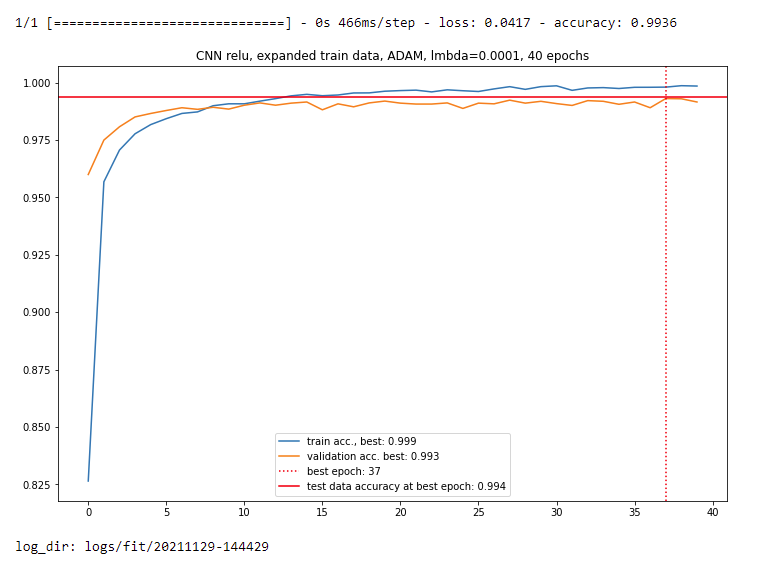

<h2>today's benchmark:</h2>

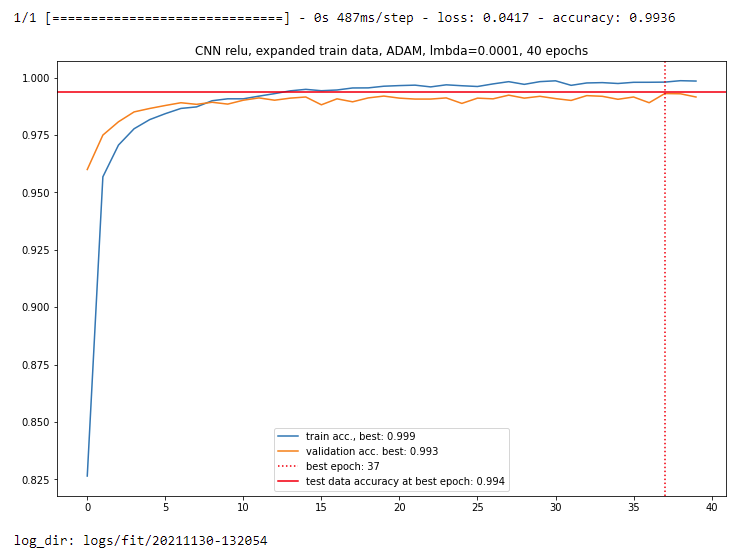

<h1>results check out, we can continue</h1>

<h1></h1>
<h1>change pool1 size to 2x2:</h1>

checkpoint_filepath: C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\20211130-133025
lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
________________________________________________

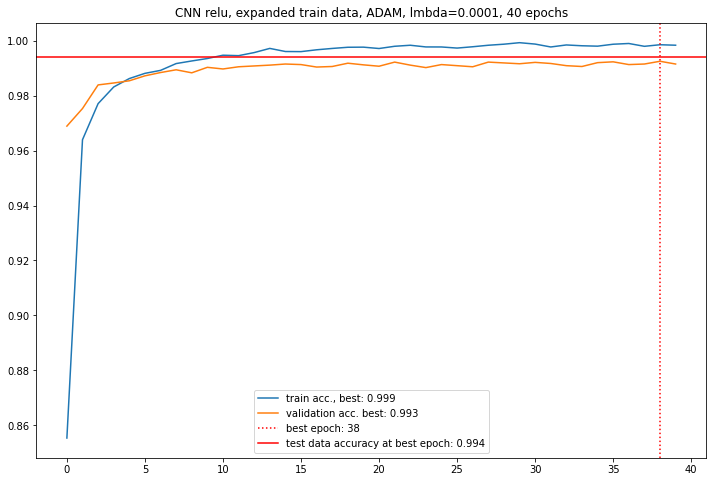

log_dir: logs/fit/20211130-133025


Reusing TensorBoard on port 6006 (pid 16568), started 2:43:20 ago. (Use '!kill 16568' to kill it.)

In [15]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
    load_model_path=None,
    filter_1=32,
    kernel_1=(5,5),
    pool___1=(2,2), # experiment
    stride_1=(2,2),
    filter_2=32,
    kernel_2=(5,5),
    pool___2=(2,2),
    stride_2=(2,2),
    dense__1=1000
)

%reload_ext tensorboard
%tensorboard --logdir logs/fit --host localhost


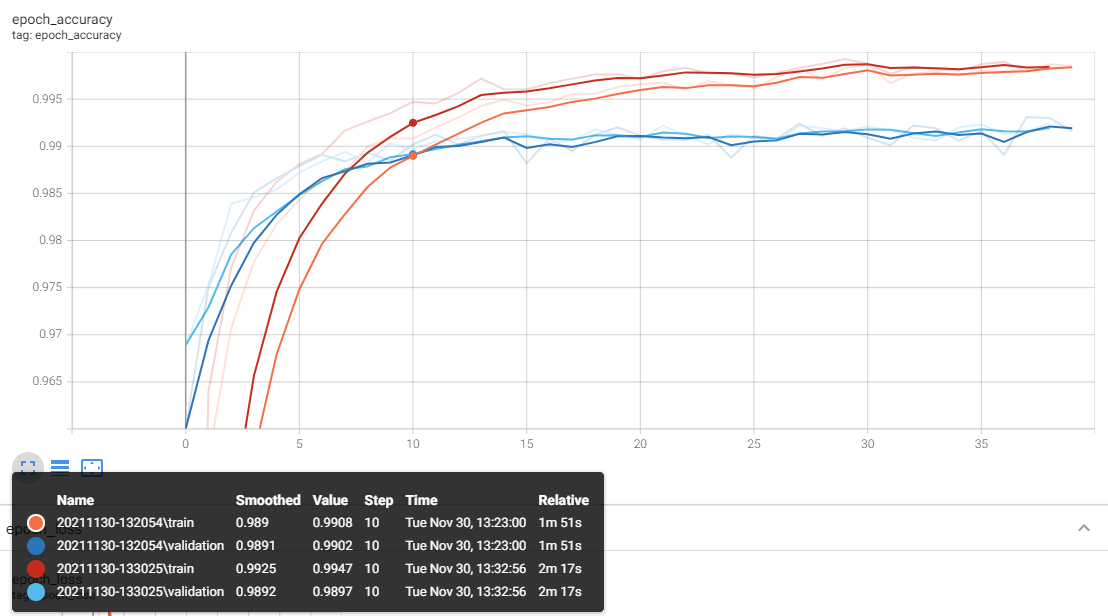

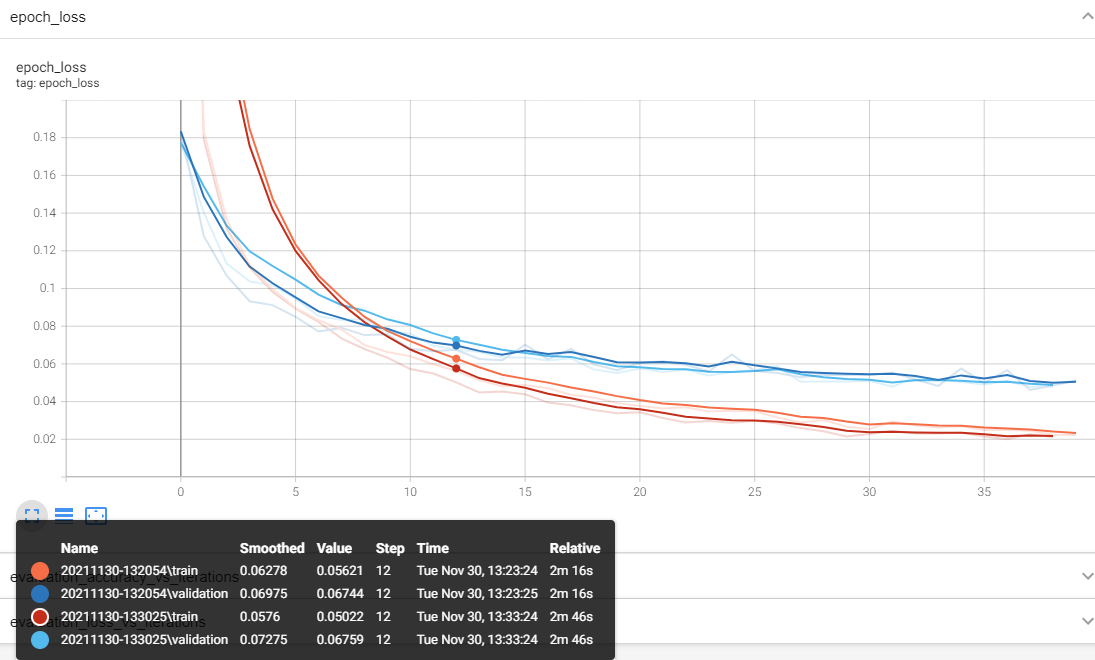

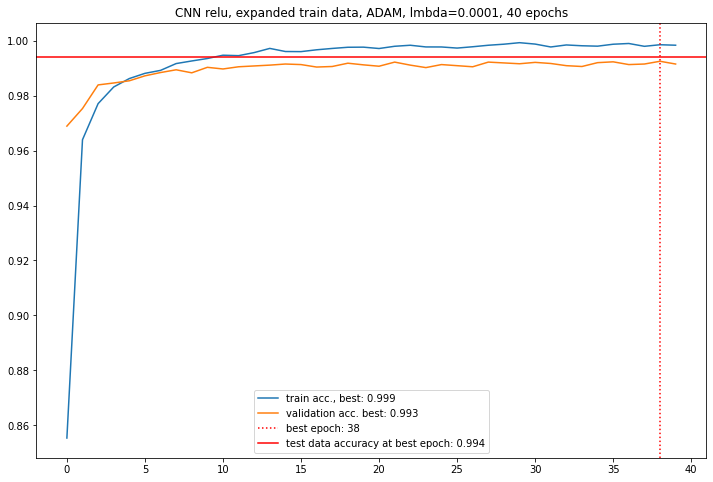

<h3>133025, 132054 : poolsize=(3,3), poolsize=(2,2).</h3>
<h3>Test Accuracy: (3,3), (2,2) : 99.36%, 99.39%.</h3>
<h3>poolsize=(2,2)'s training accuracy seems to grow faster, and validation cost seems to be a little lower than (3,3).</h3>
<h3>the difference is too small for me to make any judgements.</h3>



<h1>What if we increase the pooling size?</h1>

checkpoint_filepath: C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\20211130-135727
lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 32)          25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
________________________________________________

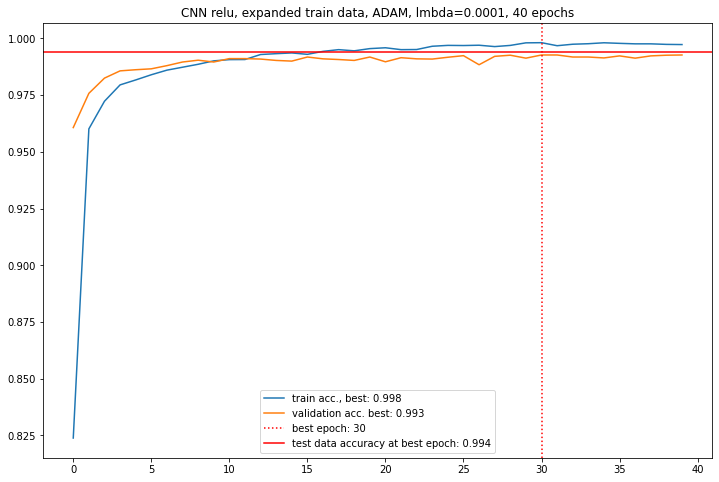

log_dir: logs/fit/20211130-135727


Reusing TensorBoard on port 6006 (pid 16568), started 3:08:39 ago. (Use '!kill 16568' to kill it.)

In [19]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
    load_model_path=None,
    filter_1=32,
    kernel_1=(5,5),
    pool___1=(6,6), # experiment, 2X benchmark
    stride_1=(2,2),
    filter_2=32,
    kernel_2=(5,5),
    pool___2=(2,2),
    stride_2=(2,2),
    dense__1=1000
)

%reload_ext tensorboard
%tensorboard --logdir logs/fit --host localhost


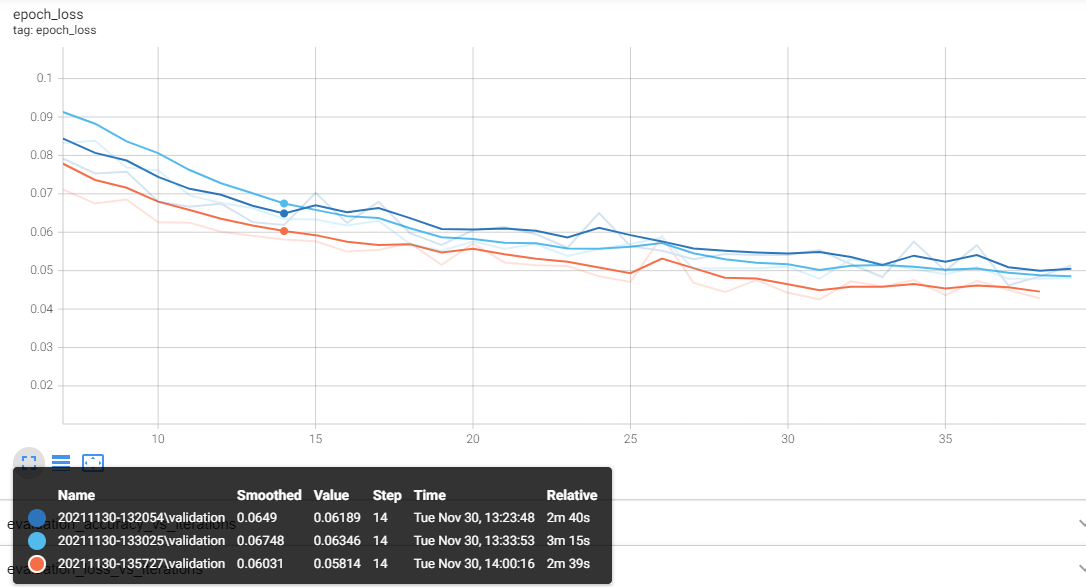

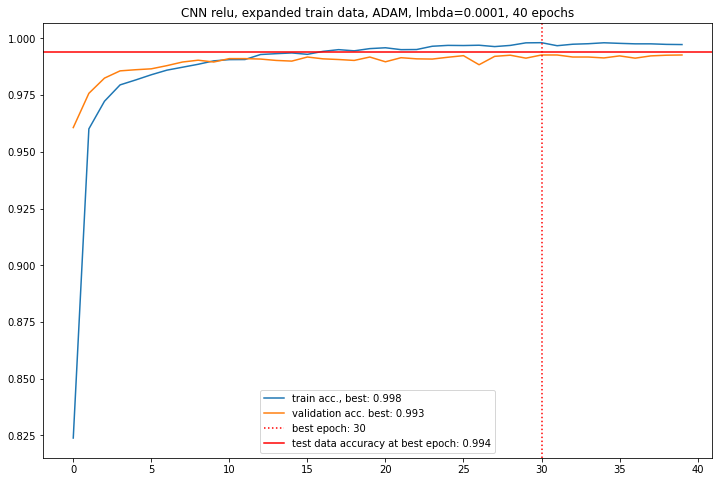

<h3>135727, 133025, 132054 : poolsize=(6,6), poolsize=(3,3), poolsize=(2,2).</h3>
<h3>Test Accuracy: (6,6), (3,3), (2,2) : 99.40% 99.36%, 99.39%.</h3>
<h3>poolsize=(6,6)'s validation cost seems to be the lowest of 3.<h3/>



<h1>What if we increase the pooling size even more?</h1>

checkpoint_filepath: C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\20211130-141558
lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 32)          25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
________________________________________________

Epoch 33/40
75/75 [==============================] - 9s 114ms/step - loss: 0.0309 - accuracy: 0.9953 - val_loss: 0.0540 - val_accuracy: 0.9886
Epoch 34/40
75/75 [==============================] - 9s 123ms/step - loss: 0.0308 - accuracy: 0.9953 - val_loss: 0.0538 - val_accuracy: 0.9889
Epoch 35/40
75/75 [==============================] - 8s 113ms/step - loss: 0.0307 - accuracy: 0.9956 - val_loss: 0.0483 - val_accuracy: 0.9912
Epoch 36/40
75/75 [==============================] - 8s 109ms/step - loss: 0.0315 - accuracy: 0.9948 - val_loss: 0.0478 - val_accuracy: 0.9910
Epoch 37/40
75/75 [==============================] - 8s 112ms/step - loss: 0.0287 - accuracy: 0.9959 - val_loss: 0.0499 - val_accuracy: 0.9898
Epoch 38/40
75/75 [==============================] - 8s 105ms/step - loss: 0.0267 - accuracy: 0.9967 - val_loss: 0.0455 - val_accuracy: 0.9906
Epoch 39/40
75/75 [==============================] - 8s 110ms/step - loss: 0.0284 - accuracy: 0.9959 - val_loss: 0.0466 - val_accuracy: 0.9900

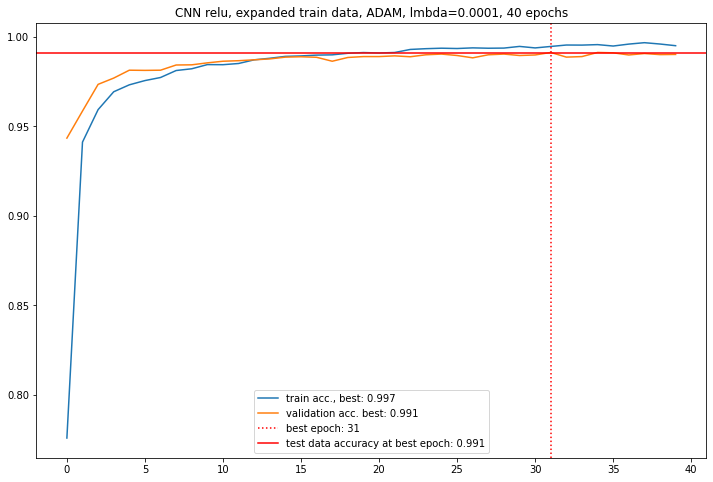

log_dir: logs/fit/20211130-141558


Reusing TensorBoard on port 6006 (pid 16568), started 3:25:49 ago. (Use '!kill 16568' to kill it.)

In [21]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
    load_model_path=None,
    filter_1=32,
    kernel_1=(5,5),
    pool___1=(9,9), # experiment, 3X benchmark
    stride_1=(2,2),
    filter_2=32,
    kernel_2=(5,5),
    pool___2=(2,2),
    stride_2=(2,2),
    dense__1=1000
)

%reload_ext tensorboard
%tensorboard --logdir logs/fit --host localhost


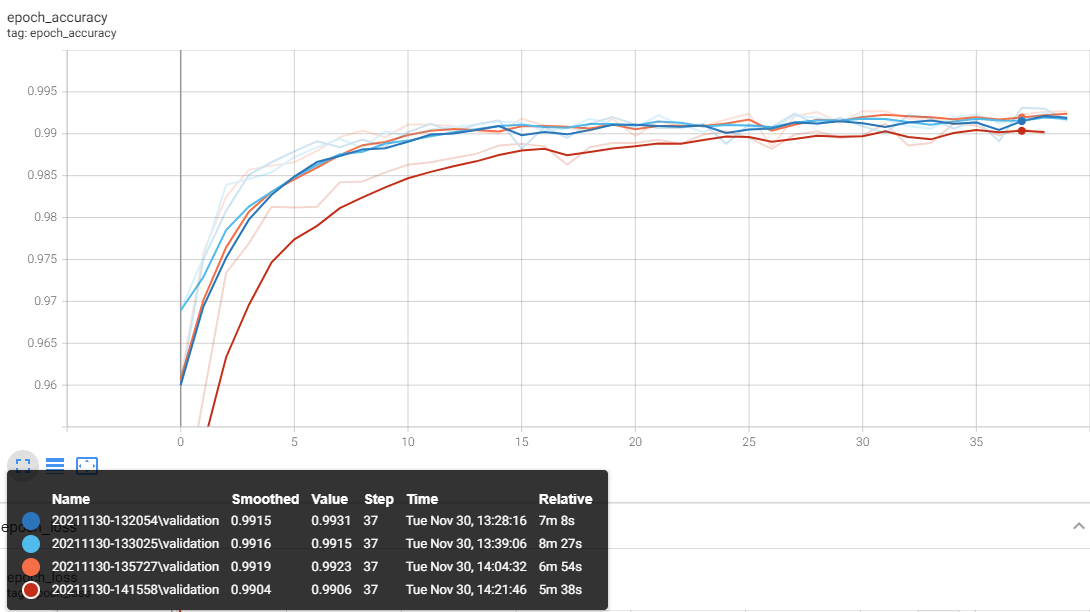

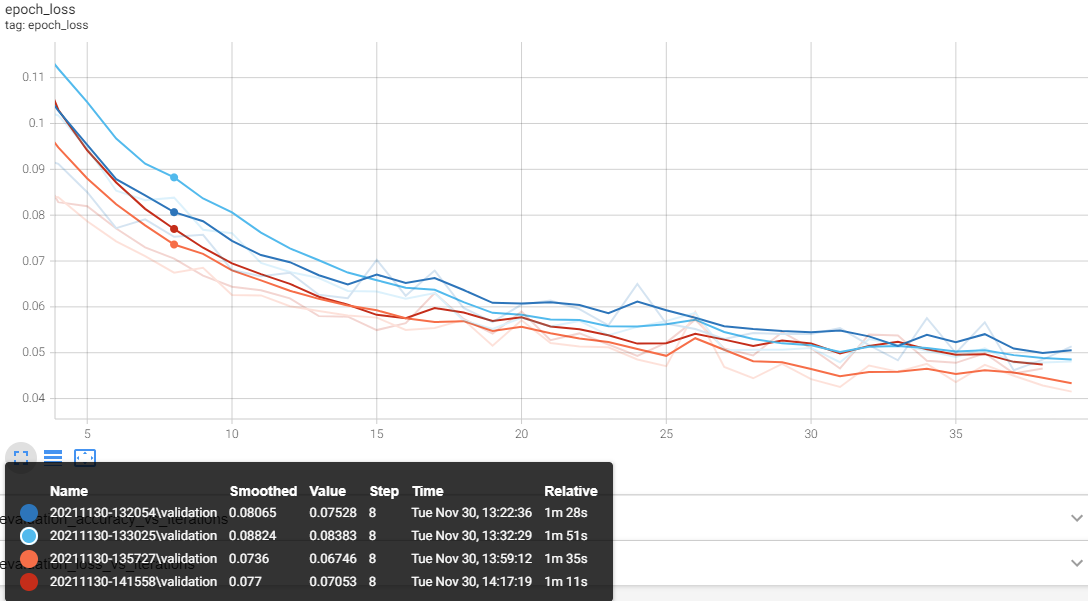

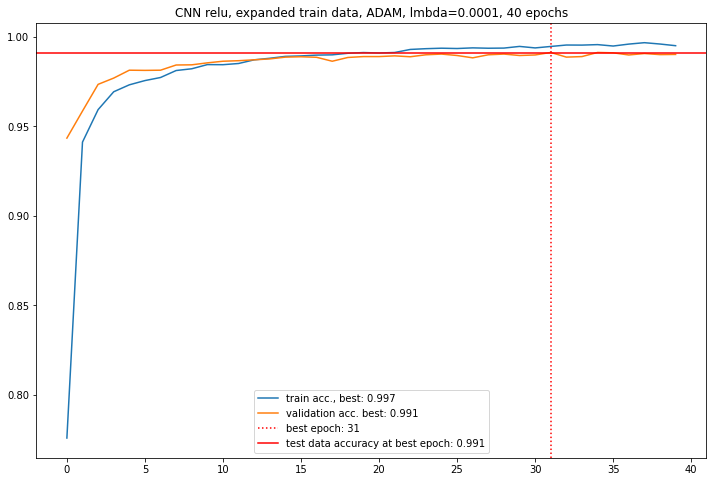

<h3>141558, 135727, 133025, 132054 : poolsize=(9,9), poolsize=(6,6), poolsize=(3,3), poolsize=(2,2).</h3>
<h3>Test Accuracy: (9,9), (6,6), (3,3), (2,2) : 99.10%, 99.40% 99.36%, 99.39%.</h3>
<h3>poolsize=(6,6)'s validation cost seems to be the lowest of 4.<h3/>


<h1>Against my intuition, smallest pooling size does not yield the best result (at least not for 40 epochs using sub-sampled training data).</h1>
<h4>For a more serious testing I should repeat these tests with multiple random seeds, but for now I will move on to tune other parameters<h4/>

<h1>Fixing layer1 pooling size to 6x6.</h1>
<h1>Now I will look at the effect of number of filters.<h1/>
<h3>filters = 32 -> 64:</h3>

checkpoint_filepath: C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\20211130-143341
lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
__________________________________________________

Epoch 36/40
75/75 [==============================] - 26s 349ms/step - loss: 0.0216 - accuracy: 0.9984 - val_loss: 0.0415 - val_accuracy: 0.9937
Epoch 37/40
75/75 [==============================] - 27s 355ms/step - loss: 0.0216 - accuracy: 0.9984 - val_loss: 0.0403 - val_accuracy: 0.9932
Epoch 38/40
75/75 [==============================] - 26s 350ms/step - loss: 0.0214 - accuracy: 0.9982 - val_loss: 0.0473 - val_accuracy: 0.9918
Epoch 39/40
75/75 [==============================] - 26s 342ms/step - loss: 0.0220 - accuracy: 0.9981 - val_loss: 0.0453 - val_accuracy: 0.9920
Epoch 40/40
75/75 [==============================] - 26s 341ms/step - loss: 0.0208 - accuracy: 0.9982 - val_loss: 0.0486 - val_accuracy: 0.9909
total time: 965.639771938324

acc [0.8437866568565369, 0.969706654548645, 0.978826642036438, 0.9841200113296509, 0.9865333437919617, 0.9881066679954529, 0.9890666604042053, 0.9910266399383545, 0.9918933510780334, 0.9932933449745178, 0.9932533502578735, 0.9937199950218201, 0.99446

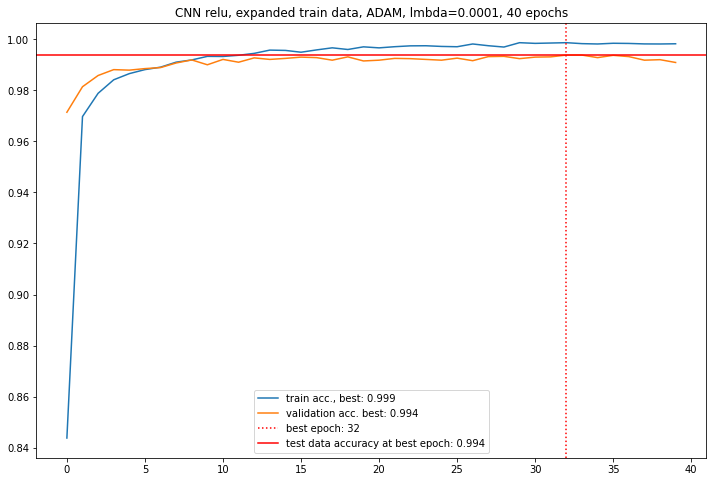

log_dir: logs/fit/20211130-143341


Reusing TensorBoard on port 6006 (pid 16568), started 3:53:34 ago. (Use '!kill 16568' to kill it.)

In [14]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


n_filter=64 #experiment, 2x benchmark


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
    load_model_path=None,
    filter_1=n_filter,
    kernel_1=(5,5),
    pool___1=(6,6), # new benchmark
    stride_1=(2,2),
    filter_2=n_filter,
    kernel_2=(5,5),
    pool___2=(2,2),
    stride_2=(2,2),
    dense__1=1000
)

%reload_ext tensorboard
%tensorboard --logdir logs/fit --host localhost


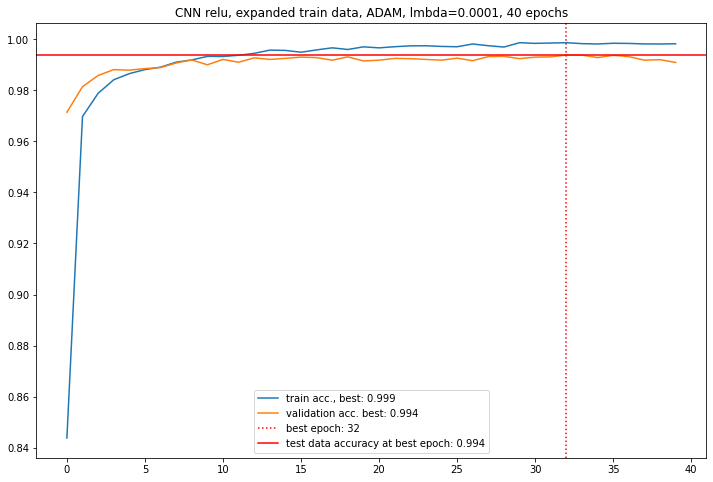

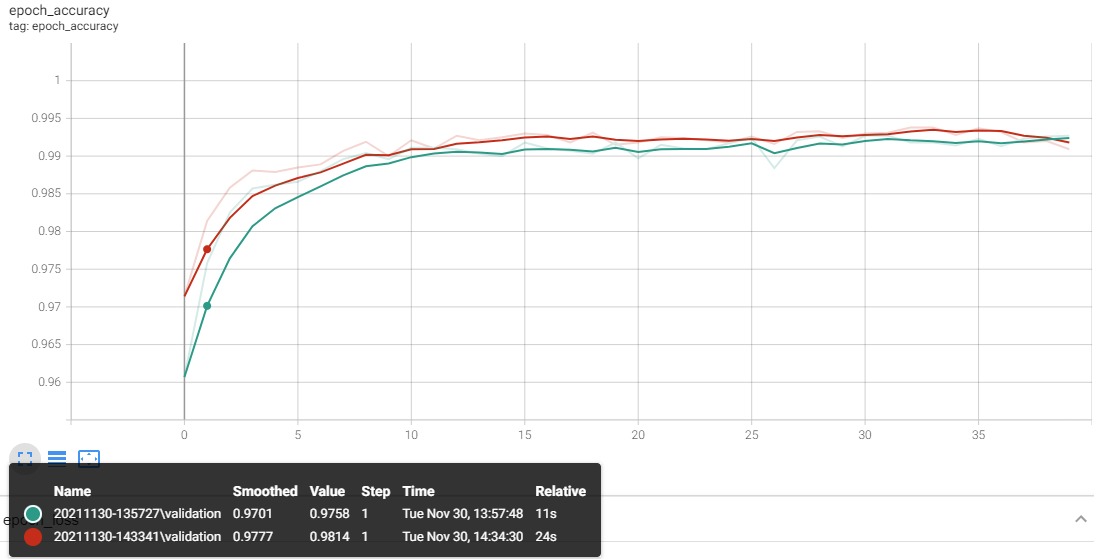

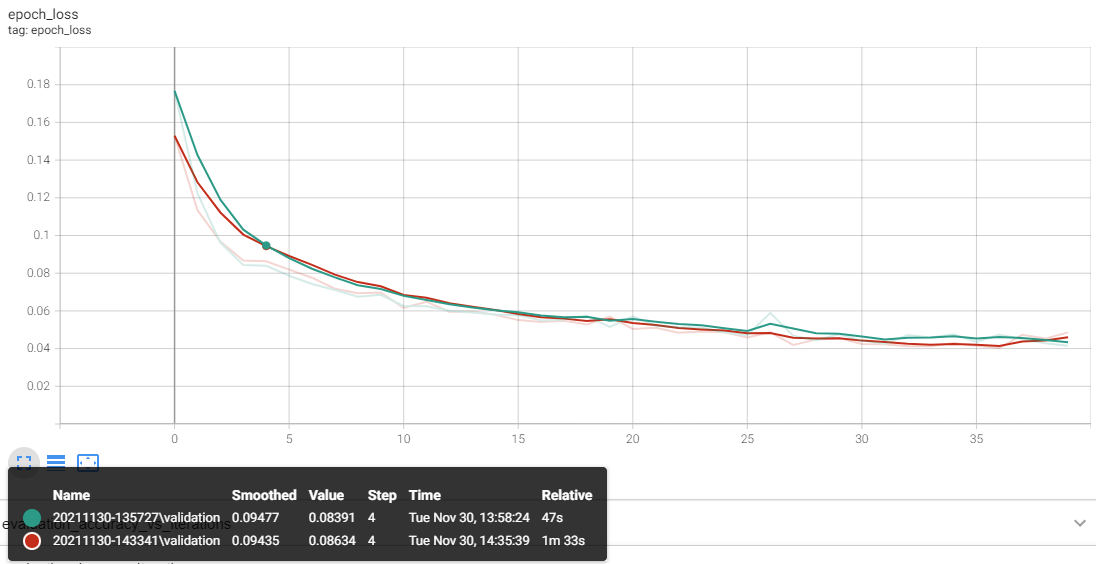

<h2>poolsize=(6,6)</h2>
<h3>135727, 143341 : filter=32, filter=64.</h3>
<h3>Test Accuracy: filter=32:99.40, filter=64: 99.39%.</h3>
<h3>The differences are too small.<h3/>

In [ ]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


n_filter=64*2 #experiment, 4x benchmark


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
    load_model_path=None,
    filter_1=n_filter,
    kernel_1=(5,5),
    pool___1=(6,6), # new benchmark
    stride_1=(2,2),
    filter_2=n_filter,
    kernel_2=(5,5),
    pool___2=(2,2),
    stride_2=(2,2),
    dense__1=1000
)

%reload_ext tensorboard
%tensorboard --logdir logs/fit --host localhost


checkpoint_filepath: C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\20211130-174917
lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
__________________________________________________

<h1>increasing filter greatly increases number of parameters and the calculation time!</h1>

In [14]:
# ###########################################
# ## delete all tensorboard logs:

# p = './logs/'
# shutil.rmtree(p, ignore_errors=True)

<h1>1129 Experiment:</h1>

<h4>default learning rate (0.001)</h4>

lmbda= 0.0001

n_eph= 40

batch_size= 1000

learning_rate= 0.001

beta_1= 0.9

beta_2= 0.999

epsilon= 1e-07

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              289000    
__________

1/1 [==============================] - 0s 466ms/step - loss: 0.0417 - accuracy: 0.9936


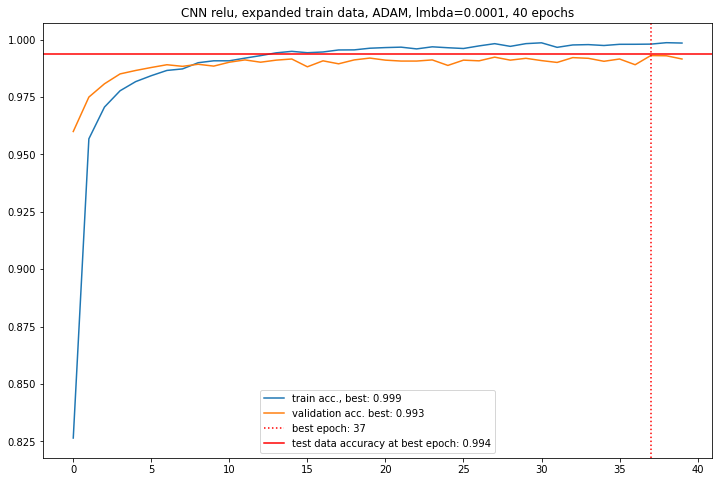

log_dir: logs/fit/20211129-144429


Reusing TensorBoard on port 6006 (pid 1096), started 1:08:03 ago. (Use '!kill 1096' to kill it.)

In [16]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 40


tb_path = train_cnn_adam_tensorboardCB(
    lmbda,
    batch_size,
    n_eph,
#     train_x, train_y,
    sub_tx, sub_ty,
    val_x, val_y,
    test_x, test_y,
    addr,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    input_shape=(28, 28, 1),
    hidden_activation=tf.nn.relu,
    out_activation=tf.nn.softmax,
)
%reload_ext tensorboard
%tensorboard --logdir tb_path


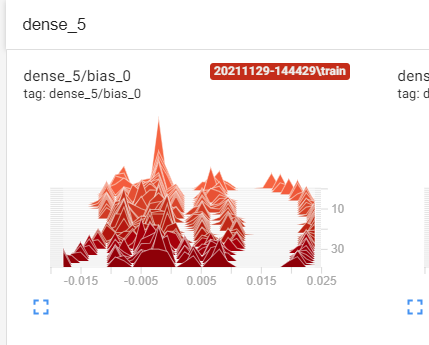

<h1>BTW, I NEED HELP WITH THIS</h1>
<h2>Load a model and continue to train. The result is not the same as the original session...</h2>

In [38]:

lmbda = 0.1 / 10 / 10 / 10
batch_size = 1000
n_eph = 128
learning_rate=5000.0
beta_1=0.9
beta_2=0.999
epsilon=1e-07
amsgrad=False
input_shape=(28, 28, 1)
hidden_activation=tf.nn.relu
out_activation=tf.nn.softmax






tx = train_x[:5000]
ty = train_y[:5000]



model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Conv2D( # no padding
        32,
        (5,5),
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.L2(
            l2=lmbda
        ),
        input_shape=input_shape
    )
)

model.add(
    tf.keras.layers.MaxPool2D(
        pool_size=(3,3), # following example of Kingma & Ba, arXiv:1412.6980v9
        strides=(2,2)
    )
)

model.add(
    tf.keras.layers.Conv2D( # no padding
        32,
        (5,5),
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.L2(
            l2=lmbda
        )
    )
)

model.add(
    tf.keras.layers.MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    )
)

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dense(
        1000,
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.L2(
            l2=lmbda
        )
    )
)

model.add(
    tf.keras.layers.Dense(
        10,
        activation=out_activation
    )
)

################################################################
optimizer_adam = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
    amsgrad=amsgrad,
    name='Adam'
)
################################################################
# compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
################################################################
model.summary()


################################################################
#  set checkpointCB
stamp = 'test123'
checkpoint_filepath = addr + '\{}'.format(stamp)
print('checkpoint_filepath:',checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)




history = model.fit(
    tx, ty, 
    epochs=1,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[model_checkpoint_callback],
    shuffle=False
)



history = model.fit(
    tx, ty, 
    epochs=4,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
#     callbacks=[model_checkpoint_callback],
    shuffle=False
)














# #############################################################
# tf.random.set_seed(42)
# #############################################################

load_model_path = r'C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env\test123'

model = tf.keras.models.load_model(load_model_path) 

history = model.fit(
    tx, ty, 
    epochs=2,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[model_checkpoint_callback],
    shuffle=False
)






Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1000)              289000    
_________________________________________________________________
dense_29 (Dense)             (None, 10)              